In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
import pyodbc
#online=Datasource expected column = Customer_ID,CONCAT(Snapshot_Date,'_',Customer_Type) as Customer_Type,Total_Transaction as FrequencyCount,Sales_Total_Amt,Last_Date_Current_Mth
query = "SELECT * FROM COM_1617.ETL_90011"
conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
online = pd.read_sql_query(query,conn)



# Convert InvoiceDate from object to datetime format
#online = pd.read_csv('C:/Users/kjx_9/PycharmProjects/pythonProject/data.csv', encoding="ISO-8859-1")
online['Date'] = pd.to_datetime(online['Date'])
online = online[online['Client ID'] != '']
online['TotalSum'] = online['Sales Amount']
#online = online['TotalSum'] > 0

# Create snapshot date
snapshot_date = online['Date'].max() + timedelta(days=1)
#print(snapshot_date)
# Grouping by CustomerID
rfm_df = online.groupby(['Client ID']).agg({
        'Date': lambda x: (snapshot_date - x.max()).days, #Get recency
        'Client ID': 'count',
        'TotalSum': 'sum'})
# Rename the columns
rfm_df.rename(columns={'Date': 'Recency',
                         'Client ID': 'Frequency',
                         'TotalSum': 'Monetary'}, inplace=True)

In [2]:
rfm_df 

,Recency,Frequency,Monetary
Client ID,,,
11301,221,3,700.45
113010,1248,1,0.00
1130100,1097,1,0.00
11301000,764,1,26.00
11301001,764,1,29.90
...,...,...,...
970995,224,1,74.00
970996,224,1,114.75
970997,224,1,82.80


C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

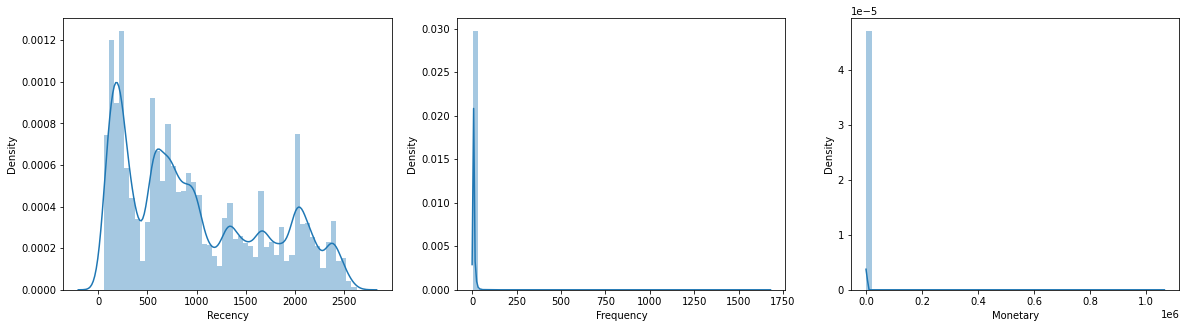

In [3]:
fig,axes = plt.subplots(1,3, figsize=(20,5))

for i, feature in enumerate(list(rfm_df.columns)):
    sns.distplot(rfm_df[feature],ax=axes[i])

In [4]:
display(rfm_df.describe())

,Recency,Frequency,Monetary
count,125482.000000,125482.000000,1.254820e+05
mean,982.209887,3.178296,3.565485e+02
std,713.849298,8.004525,3.838169e+03
min,1.000000,1.000000,0.000000e+00
25%,327.000000,1.000000,7.980000e+01
50%,800.000000,2.000000,1.611000e+02
75%,1561.000000,3.000000,3.696000e+02
max,2628.000000,1678.000000,1.063686e+06


<AxesSubplot:>

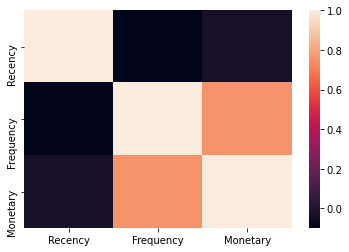

In [5]:
sns.heatmap(rfm_df.iloc[:,0:3].corr())

In [6]:
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_normalized.columns = ['n_Recency','n_Frequency','n_Monetary']
display(rfm_normalized.describe())
print(rfm_normalized)

,n_Recency,n_Frequency,n_Monetary
count,125482.000000,125482.000000,125482.000000
mean,0.373510,0.001299,0.000335
std,0.271736,0.004773,0.003608
min,0.000000,0.000000,0.000000
25%,0.124096,0.000000,0.000075
50%,0.304149,0.000596,0.000151
75%,0.593833,0.001193,0.000347
max,1.000000,1.000000,1.000000


        n_Recency  n_Frequency  n_Monetary
0        0.083746     0.001193    0.000659
1        0.474686     0.000000    0.000000
2        0.417206     0.000000    0.000000
3        0.290445     0.000000    0.000024
4        0.290445     0.000000    0.000028
...           ...          ...         ...
125477   0.084888     0.000000    0.000070
125478   0.084888     0.000000    0.000108
125479   0.084888     0.000000    0.000078
125480   0.084888     0.000000    0.000078
125481   0.084888     0.000000    0.000078

[125482 rows x 3 columns]


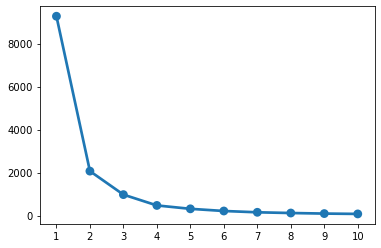

In [7]:
SSE = []
for k in range(0,10):
    kmeans =KMeans(n_clusters = k+1, random_state=1231).fit(rfm_normalized)
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)),y=SSE)
plt.show()

[[5.58063870e-01 9.91499223e-04 2.39757742e-04]
 [8.09997824e-02 1.89896191e-03 4.90703556e-04]
 [8.14871188e-01 6.92188796e-04 2.27305604e-04]
 [2.89652113e-01 1.27222325e-03 3.09301194e-04]]


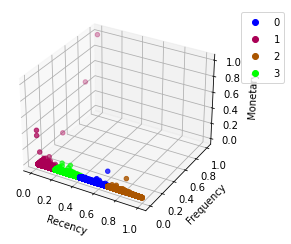

In [8]:
model = KMeans(n_clusters =4, random_state =1231).fit(rfm_normalized)

centers = model.cluster_centers_
print(model.cluster_centers_)
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
sc = ax.scatter(rfm_normalized['n_Recency'],rfm_normalized['n_Frequency'],rfm_normalized['n_Monetary'],cmap="brg",c=model.predict(rfm_normalized))
ax.scatter(centers[:,0],centers[:,1],c='black')
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1.05, 1), loc=2)


C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


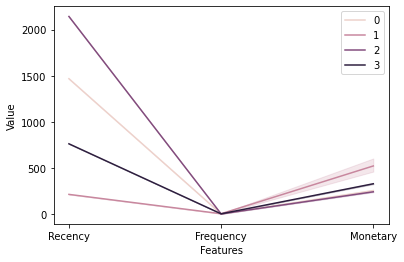

In [9]:
rfm_ = pd.DataFrame(scaler.inverse_transform(rfm_normalized))
rfm_.columns = rfm_df.columns
rfm_['CustomerId'] = rfm_df.index
rfm_['Cluster'] = model.labels_

melted_rfm_normalized = pd.melt(rfm_.reset_index(),
                               id_vars =['CustomerId','Cluster'],
                               value_vars=['Recency','Frequency','Monetary'],
                               var_name='Features',
                               value_name ='Value')
sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm_normalized)
plt.legend()

In [10]:
print(rfm_)
rfm_.groupby('Cluster').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean','min','max','count'],
})

        Recency  Frequency  Monetary CustomerId  Cluster
0         221.0        3.0    700.45      11301        1
1        1248.0        1.0      0.00     113010        0
2        1097.0        1.0      0.00    1130100        3
3         764.0        1.0     26.00   11301000        3
4         764.0        1.0     29.90   11301001        3
...         ...        ...       ...        ...      ...
125477    224.0        1.0     74.00     970995        1
125478    224.0        1.0    114.75     970996        1
125479    224.0        1.0     82.80     970997        1
125480    224.0        1.0     82.80     970998        1
125481    224.0        1.0     82.75     970999        1

[125482 rows x 5 columns]


Recency                 Frequency                 Monetary       \
                mean     min     max      mean  min     max        mean  min   
Cluster                                                                        
0        1467.395828  1115.0  1804.0  2.662163  1.0   275.0  255.031557  0.0   
1         213.786428     1.0   453.0  4.184559  1.0  1678.0  521.954743  0.0   
2        2141.881529  1805.0  2628.0  2.161030  1.0   238.0  241.787869  0.0   
3         761.981243   501.0  1114.0  3.133424  1.0   163.0  328.975708  0.0   

                            
                max  count  
Cluster                     
0          32648.95  21762  
1        1063686.49  36915  
2          35527.70  23567  
3          21509.35  43238

In [11]:
'''s1 = np.full((1,rfm_df.shape[0]-int(0.8*rfm_df.shape[0])),1)
s2 = np.full((1,rfm_df.shape[0]-int(0.8*rfm_df.shape[0])),2)
s3 = np.full((1,int(0.2*rfm_df.shape[0])),3)
s4 = np.full((1,int(0.2*rfm_df.shape[0])),4)
s5 = np.full((1,int(0.2*rfm_df.shape[0])),5)
score = np.hstack((s1,s2,s3,s4,s5)).flatten()
print(rfm_df.shape[0])
print(np.count_nonzero(score))
print(score)
print("COUNT")
print(np.count_nonzero(s1))
print(np.count_nonzero(s2))
print(np.count_nonzero(s3))
print(np.count_nonzero(s4))
print(np.count_nonzero(s5))
rfm_df = rfm_df.sort_values(by='Recency',ascending=False)
rfm_df['r_score'] = score

for i,j in zip(('Frequency','Monetary'),('f_score','m_score')):
    rfm_df=rfm_df.sort_values(by=i)
    rfm_df[j] = score

rfm_df
'''

's1 = np.full((1,rfm_df.shape[0]-int(0.8*rfm_df.shape[0])),1)\ns2 = np.full((1,rfm_df.shape[0]-int(0.8*rfm_df.shape[0])),2)\ns3 = np.full((1,int(0.2*rfm_df.shape[0])),3)\ns4 = np.full((1,int(0.2*rfm_df.shape[0])),4)\ns5 = np.full((1,int(0.2*rfm_df.shape[0])),5)\nscore = np.hstack((s1,s2,s3,s4,s5)).flatten()\nprint(rfm_df.shape[0])\nprint(np.count_nonzero(score))\nprint(score)\nprint("COUNT")\nprint(np.count_nonzero(s1))\nprint(np.count_nonzero(s2))\nprint(np.count_nonzero(s3))\nprint(np.count_nonzero(s4))\nprint(np.count_nonzero(s5))\nrfm_df = rfm_df.sort_values(by=\'Recency\',ascending=False)\nrfm_df[\'r_score\'] = score\n\nfor i,j in zip((\'Frequency\',\'Monetary\'),(\'f_score\',\'m_score\')):\n    rfm_df=rfm_df.sort_values(by=i)\n    rfm_df[j] = score\n\nrfm_df\n'

In [12]:
#Next method--------------------------------------------------------------------------------------------------------------------

In [13]:
# Rename the columns
rfm =rfm_df
print(rfm)

# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm['Recency'].rank(method='first'), q=4, labels=r_labels)

# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)

# Create new columns R and F 
rfm = rfm.assign(R = r_groups.values, F = f_groups.values)

# Create labels for Monetary
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(rfm['Monetary'].rank(method='first'), q=4, labels=m_labels)

# Create new column M for Monetary
rfm = rfm.assign(M = m_groups.values)



# Calculation for RFM score (R+F+M)
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment_Concat'] = rfm.apply(join_rfm, axis=1)

# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return ('Can\'t Loose Them')
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return ('Champions')
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return ('Loyal')
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return ('Potential')
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return ('Promising')
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return ('Needs Attention')
    else:
        return ('Require Activation')
def rfm_level_label(df):
    if df['RFM_Score'] >= 9:
        return (1)
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return (2)
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return (3)
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return (4)
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return (5)
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return (6)
    else:
        return (7)
    
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm['RFM_Level_Label'] = rfm.apply(rfm_level_label, axis=1)

print(rfm)

           Recency  Frequency  Monetary
Client ID                              
11301          221          3    700.45
113010        1248          1      0.00
1130100       1097          1      0.00
11301000       764          1     26.00
11301001       764          1     29.90
...            ...        ...       ...
970995         224          1     74.00
970996         224          1    114.75
970997         224          1     82.80
970998         224          1     82.80
970999         224          1     82.75

[125482 rows x 3 columns]
           Recency  Frequency  Monetary  R  F  M RFM_Segment_Concat  \
Client ID                                                             
11301          221          3    700.45  4  3  4          4.03.04.0   
113010        1248          1      0.00  2  1  1          2.01.01.0   
1130100       1097          1      0.00  2  1  1          2.01.01.0   
11301000       764          1     26.00  3  1  1          3.01.01.0   
11301001       764         

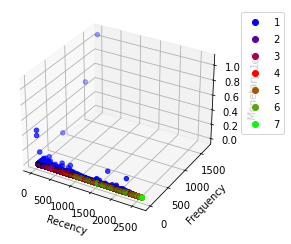

In [14]:
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

sc = ax.scatter(rfm['Recency'],rfm['Frequency'],rfm['Monetary'],cmap="brg",c=rfm['RFM_Level_Label'])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

Text(0, 0.5, 'Inertia')

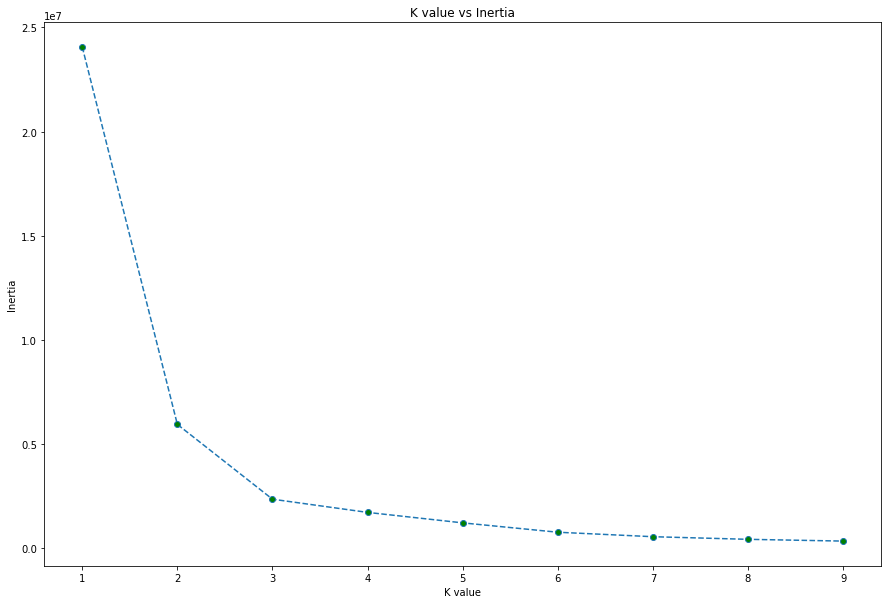

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler,StandardScaler

# Scaling with Robust Scaler
rfm_model = rfm[['Recency','Frequency','Monetary']]
standar = RobustScaler()
standar.fit(rfm_model)
rfm_model = standar.transform(rfm_model)
rfm_model = pd.DataFrame(rfm_model, columns=['Recency','Frequency','Monetary'])
rfm_model['Clinet ID'] = rfm.index

# Find K best with Elbow Method 
## Modeling with KMeans
inertia_list = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_model[['Recency','Frequency','Monetary']])
    inertia_list.append(kmeans.inertia_)
    
# Show graph elbow method
plt.figure(figsize=(15,10))
plt.plot(range(1,10),inertia_list,marker='o',markerfacecolor='green',linestyle='dashed')
plt.title('K value vs Inertia')
plt.xlabel('K value')
plt.ylabel('Inertia')

,Recency,Frequency,Monetary
count,125482.000000,125482.000000,125482.000000
mean,0.373510,0.001299,0.000335
std,0.271736,0.004773,0.003608
min,0.000000,0.000000,0.000000
25%,0.124096,0.000000,0.000075
50%,0.304149,0.000596,0.000151
75%,0.593833,0.001193,0.000347
max,1.000000,1.000000,1.000000


         Recency  Frequency  Monetary
0       0.083746   0.001193  0.000659
1       0.474686   0.000000  0.000000
2       0.417206   0.000000  0.000000
3       0.290445   0.000000  0.000024
4       0.290445   0.000000  0.000028
...          ...        ...       ...
125477  0.084888   0.000000  0.000070
125478  0.084888   0.000000  0.000108
125479  0.084888   0.000000  0.000078
125480  0.084888   0.000000  0.000078
125481  0.084888   0.000000  0.000078

[125482 rows x 3 columns]
[[8.89346398e-01 4.23128199e-04 1.71882542e-04]
 [7.89641034e-02 1.90488780e-03 4.93855299e-04]
 [5.60045024e-01 9.41127052e-04 2.32858568e-04]
 [2.41891273e-01 1.46933684e-03 3.48903521e-04]
 [7.48250735e-01 8.97498460e-04 2.66846973e-04]
 [3.68156997e-01 1.03248523e-03 2.52163935e-04]]


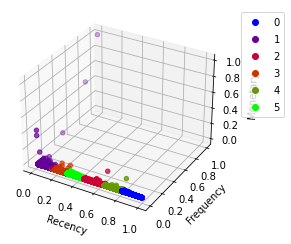

In [16]:
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_normalized))
rfm_normalized.columns = ['Recency','Frequency','Monetary']
display(rfm_normalized.describe())
print(rfm_normalized)

model = KMeans(n_clusters =6, random_state =1231).fit(rfm_normalized)

centers = model.cluster_centers_
print(model.cluster_centers_)
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
sc = ax.scatter(rfm_normalized['Recency'],rfm_normalized['Frequency'],rfm_normalized['Monetary'],cmap="brg",c=model.predict(rfm_normalized))
ax.scatter(centers[:,0],centers[:,1],c='black')
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1.05, 1), loc=2)


In [17]:
#K Mean on each col--------------------------------------------------------------------------------------------------------